<a href="https://colab.research.google.com/github/ma2sevich222/study_projects/blob/main/Regression._Estimated%20salary%20based%20on%20hh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import re
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split

from google.colab import files

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
fixed_df = pd.read_csv('/content/drive/My Drive/hh.csv')

In [ ]:
print(fixed_df.shape)

(66945, 13)


In [ ]:
n = 2
for i in range(len(fixed_df.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", fixed_df.values[n][i])

0   2
1   Мужчина ,  44 года , родился 21 февраля 1975
2   65 000 руб.
3   Системный администратор, Системный инженер
4   Липецк , готов к переезду , готов к командировкам
5    полная занятость
6    удаленная работа, полный день, вахтовый метод
7   Опыт работы 19 лет 9 месяцев

Системный администратор, Системный инженер 65 000 руб. Информационные технологии, интернет, телеком Сетевые технологии Системный администратор CTO, CIO, Директор по IT Занятость: полная занятость График работы: удаленная работа, полный день, вахтовый метод Опыт работы 19 лет 9 месяцев Октябрь 2018 — по настоящее время 7 месяцев СПССПК "ЭКОПТИЦА" Липецкая область , ecoptica.com Сельское хозяйство ... Земледелие, растениеводство, животноводство Сельскохозяйственная продукция (продвижение, оптовая торговля) Системный администратор Администрирование серверов Windows Server 2016(AD, DNS, DHCP, WSUS, IIS, FS, RDG, RDS, TS). Поддержка распределенной ЛВС на 350 рабочих станций windows(7, 10) в разветвленной много доменн

#Парсим базу

In [ ]:

fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) 

i=0
for j in range(12):  
    for i in range(fixed_df.shape[0]): 
        if type(fixed_df.values[i][j])!=float: 
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")


In [ ]:
# Данные о поле
def getParameterSex(arg):
  out = 0
  
  #Если М, то 1. По умолчанию 0 - Ж
  if(arg[0] == "М"):
    out = 1
  return out

# Данные о возрасте
def getParameterAge(arg):
  out = 0
  
  #Год рождения - 2019
  if (len(arg) > 7):
    ageStr = arg[len(arg)-4:len(arg)] # вычитаем  день и месяц рождения, оставляем последние 4 цифры - год
    out = 2020 - int(ageStr) # от текущего (2020) вычитаем год рождения
  
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  out = getParameterAge(arg)
  outClass = 0
  if (out > 18): # больше, чем 18 лет
    outClass = 1
  if (out > 23): # больше, чем 23 лет
    outClass = 2
  if (out > 28): # больше, чем 28 лет
    outClass = 3
  if (out > 33): # больше, чем 33 лет
    outClass = 4
  if (out > 38): # больше, чем 38 лет
    outClass = 5
  if (out > 43): # больше, чем 43 лет
    outClass = 6
  if (out > 48): # больше, чем 48 лет
    outClass = 7
  if (out > 53): # больше, чем 53 лет
    outClass = 8
  if (out > 58): # больше, чем 58 лет
    outClass = 9 
  if (out > 63): # больше, чем 63 лет
    outClass = 10
    
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Зарплата
def getParameterSalary(arg):
    global salaryStr, num #т.к. используем, меняем в функции
    
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(arg) != float):
        num = arg
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','')
        
        # Конвертируем в рубли, если валюта
        if curr == 'USD':
            num = float(num)*65
        elif curr == 'KZT':
            num = float(num)*0.17
        elif curr=='грн':
            num = float(num)*2.6
            
        salaryStr = num
        
    #Строчную запись зп в целое число    
    out = int(salaryStr)

    return out

# Данные о городе
def getParameterCity(arg):
  out = [0, 0, 0, 1] #если никаких данных нет

  # Все, что до запятой
  index = 0
  while (arg[index] != ","):
    index += 1
    
  # Строка до "," - наш город
  cityStr = arg[:index]
  
  # Список городов миллиоников, если не Москва или Санкт-Петербург
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  
  # кодируем вектор города
  if (cityStr == "Москва"):
    out[0] = 1
    out[3] = 0
  if (cityStr == "Санкт-Петербург"):
    out[1] = 1
    out[3] = 0
  if (cityStr in millionCities):
    out[2] = 1
    out[3] = 0
  
  return out

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out = [0, 0, 0, 0]
  
  if ("стажировка" in arg):
    out[0] = 1
  if ("частичная занятость" in arg):
    out[1] = 1
  if ("проектная работа" in arg):
    out[2] = 1
  if ("полная занятость" in arg):
    out[3] = 1
  
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  
  if ("гибкий график" in arg):
    out[0] = 1
  if ("полный день" in arg):
    out[1] = 1
  if ("сменный график" in arg):
    out[2] = 1
  if ("удаленная работа" in arg):
    out[3] = 1
  
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] #По умолчанию не указано
  
  if ("Высшее" in arg):
    out[0] = 1
  if ("Higher education" in arg):
    out[0] = 1
  if ("Среднее специальное" in arg):
    out[1] = 1
  if ("Неоконченное высшее" in arg):
    out[2] = 1
  if ("Среднее образование" in arg):
    out[3] = 1
  
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  out = 0
  
  #Проверяем, если не пустая строка
  symbols = 0
  for s in arg:
    if (s != " "):
      symbols += 1
  
  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
    spacesIndexes = []
    index = 0
    while ((len(spacesIndexes) < 5) & (index < len(arg))):
      if (arg[index] == " "):
        spacesIndexes.append(index)
      index += 1

    years = 0
    months = 0

    #print(arg)
    # Проверяем, если первый символ после второго пробела - м(месяц)
    if (arg[spacesIndexes[2]+1] != "м"):
      if (len(spacesIndexes) >= 3):
        yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
        years = int(yearsStr)
        #print("Лет - ", yearsStr)
      #else:
        #print("Нет годов")
      
      
      if (len(spacesIndexes) >= 5):
        monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
        #print("Месяцев - ", monthsStr)
        if(arg[spacesIndexes[2]+1] == "м"):
          months = int(monthsStr)
      #else:
        #print("Нет месяцев")
        
    else:
      if (len(spacesIndexes) >= 3):
        monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
        months = int(monthsStr)
        #print("Месяцев - ", monthsStr)
      #else:
        #print("Нет годов")

    out = 12*years + months
  
  return out

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9 
  if (out > 240): # если больше 240 месяцев
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  sex = getParameterSex(val[0]) #параметры о поле
  age = getParameterAgeVect(val[0]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = [] 
  
# Склеиваем все параметры в вектор  
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    
    # Все, что не зарплата - обучающая выборка
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)
  
  #minY = yTrain.min()
  #maxY = yTrain.max()
  #yTrain = (yTrain - minY)/(maxY-minY)
  
  return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(fixed_df.values)

#Используем простые текстовые данные

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):
  # Убираем нетекстовые символы
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower()
  
  words = []
  currWord = ""
  for symbol in text:
    # если не кодировка и не пробел, то добавляем символ, пока не конец слова
    if (symbol != "\ufeff"):
      if (symbol != " "):
        currWord += symbol
      else:
        if (currWord != ""):
          words.append(currWord)
          currWord = ""

  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  wCount = dict.fromkeys(allWords, 0)

  for word in allWords:
    wCount[word] += 1

  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)

  sortedWords = []

  for word in wordsList:
    sortedWords.append(word[0])

  wordIndexes = dict.fromkeys(allWords, 0)
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  for word in words:
    
    wordIndex = 0
    wordInVocabulary = word in vocabulary
    
    if (wordInVocabulary):
      index = vocabulary[word]
      if (index < maxWordsCount):
        wordIndex = index
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  
  for x in trainVector:
    out[x] = 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
    
  return np.array(out)


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag с множественным вхождением
##########################
def changeXTo01Multi(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  
  for x in trainVector:
    out[x] += 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag с множественным вхождением
##########################
def changeSetTo01Multi(trainSet, wordsCount):
  out = []
  
  for x in trainSet:
    out.append(changeXTo01Multi(x, wordsCount))
    
  return np.array(out)

# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []
  allTextProf = ""
  
  for val in values:
    currText = ""
    if (type(val[3]) != float):
      currText += val[2]
    if (type(val[7]) != float):
      currText += " " + val[7]
    
    allTextProf += currText + " "
    if (getParameterSalary(val[1]) != -1): # Проверяем, если есть данные о зарплате
      xTrainTProf.append(currText)
  
  xTrainTProf = np.array(xTrainTProf)
  
  return (xTrainTProf, allTextProf)

# Выкачиваем данные по резюме
def getXTrainTRez(values):
  xTrainTRez = []
  allTextRez = ""
  
  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]
    
    allTextRez += currText + " "
    if (getParameterSalary(val[1]) != -1):
      xTrainTRez.append(currText)
  
  xTrainTRez = np.array(xTrainTRez)
  
  return (xTrainTRez, allTextRez)

# Делаем векторное представление слов
def changeSetToIndexes(xTrainProf, vocabulary, maxWordsCount):
  xTrainProfIndexes = []
  
  for text in xTrainProf:
    currWords = text2Words(text)
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)
    xTrainProfIndexes.append(currIndexes)
  
  xTrainProfIndexes = np.array(xTrainProfIndexes)
  
  return xTrainProfIndexes

In [ ]:
(xTrainTProf, allTextProf) = getXTrainTProf(fixed_df.values)

In [ ]:
print(len(allTextProf)) # длина всего словаря профессий
print(allTextProf[:200]) # пример текста всех профессий (первые 20 символов)

3427505
Старший администратор Трц Ривьера Старший IT инженер Эскорт-Центр, Москва, ЗАО Системный администратор, Системный инженер СПССПК "ЭКОПТИЦА" Web-программист, Web-администратор, Web-мастер ГБУ "МДОО" Ст


In [ ]:
words = text2Words(allTextProf) # разбиваем текст профессий на слова
vocabulary = createVocabulary(words)
print(len(vocabulary))

45833


In [ ]:
xTrainProfIndexes = changeSetToIndexes(xTrainTProf, vocabulary, 10000) 
xTrainProf01 = changeSetTo01(xTrainProfIndexes, 10000) # Формат 0-1

In [ ]:
n = 0
print(xTrainTProf[n]) # профессия
print(xTrainProfIndexes[n]) # профессия через индексы

Старший администратор Трц Ривьера
[81, 3, 1418, 2242]


In [ ]:
print(xTrainProf01.shape)

(66945, 10000)


#Загружаем сложные текстовые данные

In [ ]:
(xTrainTRez, allTextRez) = getXTrainTRez(fixed_df.values)

# Преобразуем в слова тексты резюме
words = text2Words(allTextRez)
print(len(words))

39095716


In [ ]:
vocabularyRez = createVocabulary(words[:1000000]) # Словарь из 5000000 слов
print(len(vocabularyRez))

54324


In [ ]:
maxWordsCount = 2000 # 1000 самых популярных слов, чтобы избежать переобучения
xTrainRezIndexes = changeSetToIndexes(xTrainTRez, vocabularyRez, maxWordsCount) # Превращаем слова в индексы, используем самые частые 
xTrainRez01 = changeSetTo01(xTrainRezIndexes, maxWordsCount) # Формат 0-1

In [ ]:
print(len(vocabularyRez)) # Длина словаря 
print(xTrainRez01.shape) # Размер выборки самых частых слов
print(xTrainRez01[555]) # Пример из отформатированной выборки

54324
(66945, 2000)
[1. 1. 1. ... 0. 0. 0.]


#Ограничиваем влияние экстремльных значений

In [ ]:

from scipy.stats.mstats import winsorize

winz_yTrain =winsorize(yTrain, limits = (0,0.1)) 


#Составная нейронка на всех типах данных одновременно





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 50000 samples, validate on 16945 samples
Epoch 1/100





 - 46s - loss: 1684.6168 - mean_absolute_error: 29.7922 - val_loss: 746.2628 - val_mean_absolute_error: 19.6068
Epoch 2/100
 - 45s - loss: 1340.6191 - mean_absolute_error: 26.3395 - val_loss: 688.6566 - val_mean_absolute_error: 18.2727
Epoch 3/100
 - 45s - loss: 1205.4640 - mean_absolute_error: 24.9847 - val_loss: 615.1174 - val_mean_absolute_error: 17.3868
Epoch 4/100
 - 43s - loss: 1093.4879 - mean_absolute_error: 23.5995 - val_loss: 556.6167 - val_mean_absolute_error: 16.2824
Epoch 5/100
 - 42s - loss: 996.9082 - mean_absolute_error: 22.5030 - val_loss: 546.5599 - val_mean_absolute_error: 16.0931
Epoch 6/100
 - 42s - loss: 909.7311 - mean_absolute_error: 21.4672 - val_loss: 505.9866 - val_mean_absolute_error: 15.4883
Epoch 7/100
 - 42s - loss: 843.1443 - mean_absolute_error: 20.6191 - val_loss: 4

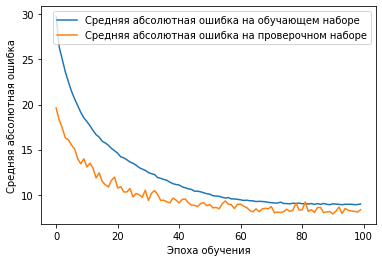

In [ ]:
maxWordsCount = 2000 # Устанавливаем самые частые и превращаем их в индексы, выборку
xTrainRezIndexes = changeSetToIndexes(xTrainTRez, vocabularyRez, maxWordsCount)
xTrainRez01 = changeSetTo01(xTrainRezIndexes, maxWordsCount)

input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainProf01.shape[1],))
input3 = Input((xTrainRez01.shape[1],))


x1 = Dense(10, activation="relu")(input1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)


x2 = Dense(25, activation="relu")(input2)
x2 = Dense(8, activation="tanh")(x2)
x2 = Dense(5, activation = "elu")(x2)



x3 = Dense(1000, activation="tanh")(input3)
x3 = Dense(20, activation = "elu")(x3)
x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x2, x3]) 

x = Dense(15, activation='linear')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) 

model = Model((input1, input2, input3), x) 

model.compile(optimizer=Adam(lr=1e-1), loss='mse', metrics=['mae'])

xTrain01_train = xTrain01[:50000]
xTrainProf01_train = xTrainProf01[:50000]
xTrainRez01_train = xTrainRez01[:50000]
yTrain_train =winz_yTrain[:50000]
xTrain01_val = xTrain01[50000:]
xTrainProf01_val = xTrainProf01[50000:]
xTrainRez01_val = xTrainRez01[50000:]
yTrain_val =winz_yTrain[50000:]

history = model.fit([xTrain01_train, xTrainProf01_train, xTrainRez01_train], 
                    yTrain_train, 
                    epochs = 100, 
                    validation_data=([xTrain01_val, xTrainProf01_val, xTrainRez01_val], 
                    yTrain_val), 
                    verbose = 2)


plt.plot(history.history['mean_absolute_error'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()